Гугл колаб доступен по ссылке https://colab.research.google.com/drive/15v5jAb1dxWanKyDd94kIpooOKdrWvhPc?usp=sharing

In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import google.colab

In [2]:
@numba.njit
def next_generation(arr, probs):
    '''Функция для генерации следующего поколения такого же размера
    arr - 3d-массив с популяциями из 0 и 1 (популяции вдоль оси 2)
    probs - массив такой же формы с вероятностями выбора особей (вероятности суммируются в 1 вдоль оси 2)
    Так как я не придумал способа сделать чисто векторными операциями, попробуем нумбу, чтоб не работало год'''
    assert arr.shape == probs.shape

    #развёрнутая форма массивов, в которой единственный уровень вложенности - подмассивы для отдельных популяций
    arr_ext = arr.reshape(arr.shape[0] * arr.shape[1], arr.shape[2])
    probs_ext = probs.reshape(probs.shape[0] * probs.shape[1], probs.shape[2])

    to_return = np.zeros((arr.shape[0] * arr.shape[1], arr.shape[2]))

    for idx in range(arr.shape[0] * arr.shape[1]):
        #проверяем, не сошлась ли ещё эта строка (есть ли смысл делать сэмплинг)
        if arr_ext[idx].sum() == 0. or arr_ext[idx].sum() == arr.shape[2]:
            to_return[idx] = arr_ext[idx]

        #эта наркомания нужна, потому что разработчики нумбы не добавили опцию p в np.random.choice
        #взято из https://github.com/numba/numba/issues/2539?ysclid=lubplvimpv458138040#issuecomment-507306369
        to_return[idx] = np.array(
            [
                arr_ext[idx][
                    np.searchsorted(
                        np.cumsum(probs_ext[idx]),
                        np.random.random(),
                        side="right"
                    )
                ] for i in range(len(arr_ext[idx]))
            ]
        )

    return to_return.reshape(arr.shape[0], arr.shape[1], arr.shape[2])

In [3]:
#надо затестить + чтоб нумба скомпилировала функцию
a = np.zeros((3,4,5))
a[:,:,0] = 1
a = np.random.default_rng().permuted(a, axis=2)
b = np.array([0.2,0.3,0.4]).reshape((3,1,1))
c = a*b

c[c == 0] = 1
c_n = c / c.sum(axis=2).reshape((3, 4, 1))

next_generation(arr=a, probs=c_n)

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]]])

In [4]:
def calc_fixation_prob_np_3d(N, s_min, s_max, step, num_iterations_per_s):
    #массив с рассматриваемыми значениями s+1 (отношение МО количества потомков у мутанта и дикого типа)
    s_linspace = np.arange(
        start=s_min,
        stop=s_max,
        step=step
    ) + 1.

    #0 - особи без мутаций
    #ось 0 - значения s, ось 1 - повторности для каждого s, ось 2 - особи внутри одной популяции
    populations = np.zeros((len(s_linspace), num_iterations_per_s, N))

    #вводим по одной мутации на популяцию, 1 - особь с мутацией
    populations[ : , : , 0 ] = 1.

    #перемешиваем внутри популяций
    populations = np.random.default_rng().permuted(populations, axis=2)

    while True:
        #в массив вероятностей выживания ставим заглушку (nan) вместо 0 (особей дикого типа)
        #иначе сойдёт с ума при s=-1
        probabilities = np.copy(populations)
        probabilities[probabilities == 0] = np.nan

        # подставляем 1+s вместо 1 (то есть мутантов)
        probabilities = probabilities * s_linspace.reshape((len(s_linspace), 1, 1))

        #а теперь заменим все nan на 1 (для дикого типа)
        np.nan_to_num(
            x=probabilities,
            copy=False,
            nan=1.
        )

        #нормируем вдоль оси 2, чтобы получить вероятности для каждой особи в популяции
        probabilities = probabilities / probabilities.sum(axis=2).reshape(len(s_linspace), num_iterations_per_s, 1)

        #применяем нумбовскую магию и генерируем следующее поколение
        populations = next_generation(populations, probabilities)

        #проверяем, не пора ли заканчивать цикл
        #если суммы по всем популяциям сошлись к 0 (удалилась мутация) или N (закрепилась мутация)
        if set(np.unique(populations.sum(axis=2))) in [
            {0.},
            {N},
            {0., N},
            {N, 0.}
        ]:
            break

    return populations.sum(axis=2).sum(axis=1) / (num_iterations_per_s * N)

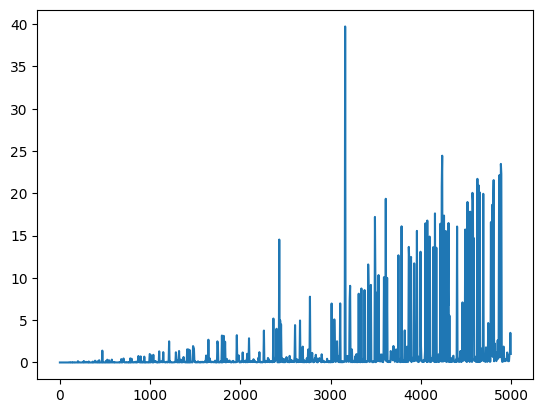

In [ ]:
#проверим скорость сходимости от N (при маленьких количестве шагов и повторностей)
import time

Ns = np.arange(1, 5000, 5)
times = np.zeros(len(Ns))

for idx in range(len(times)):
    t0 = time.time()
    calculated_probs = calc_fixation_prob_np_3d(
        N=Ns[idx],
        s_min=0.0,
        s_max=0.1,
        step=0.05,
        num_iterations_per_s=1
    )
    t = time.time()
    times[idx] = t - t0

plt.plot(Ns, times)

In [5]:
N = 20
s_min = 0.0
s_max = 0.1
step = 0.0002
num_iterations_per_s = 5000

calculated_probs = calc_fixation_prob_np_3d(
    N=N,
    s_min=s_min,
    s_max=s_max,
    step=step,
    num_iterations_per_s=num_iterations_per_s
)

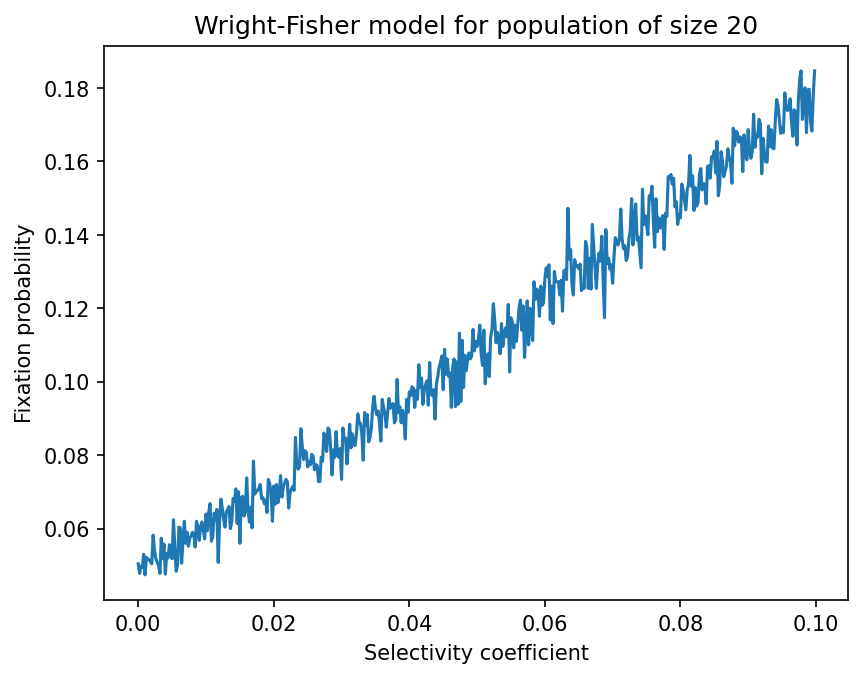

In [6]:
plt.figure(dpi=150)

plt.plot(
    np.arange(
        start=s_min,
        stop=s_max,
        step=step
    ),
    calculated_probs
)

plt.xlabel("Selectivity coefficient")
plt.ylabel("Fixation probability")
plt.title(f"Wright-Fisher model for population of size {N}")

plt.savefig("wright_fisher.png", dpi=400, facecolor="white")

In [ ]:
google.colab.files.download("wright_fisher.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>